In [31]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive  # Import Google Drive mounting utility
    drive.mount('/content/drive')  # Mount Google Drive

    # REPLACE WITH YOUR FOLDER

    base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning')

    data_folder =  Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq
    !pip install torchinfo

else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

    base_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning')
    data_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files')
    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data


In [32]:
from pathlib import Path
import sys

# Determine the storage location based on the execution environment
# If running on Google Colab, use Google Drive as storage
if 'google.colab' in str(get_ipython()):
    custom_function_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    project_folder = model_folder
    # project_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Class/Class - 6/Imagenette_project')
    kaggle_api_folder = base_folder/'data/.kaggle'

# If running locally, specify a different path
else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files')
    custom_function_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    # project_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Class/Class - 6/Imagenette_project')
    kaggle_api_folder = base_folder/'data/.kaggle'
    # project_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files


In [33]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_fmnist import FashionMNISTDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from resnet import SimpleResNet
from shared_utils import  plot_losses_acc

In [34]:
SimpleResNet??

Init signature: SimpleResNet(num_classes=120)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: Boolean represents whether this module is in training or
                evaluat

In [35]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = SimpleResNet(num_classes=10)
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 305194
Trainable parameters: 305194


In [36]:
trans1 = transforms.ToTensor()

# Transform 2: Normalize the tensor images.
# The specified mean and standard deviation values are dataset-specific.
trans2 = transforms.Normalize((0.2857,), (0.3528))

# Combine the above transformations into a single composite transform.
trans = transforms.Compose([trans1, trans2])

In [37]:
def load_datamodule(config,data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    dm = FashionMNISTDataModule(
        data_dir=data_folder,
        train_transform=trans,
        test_transform=trans,
        **config['data_module']
    )
    return dm

In [38]:
# Function to load the model
def load_model(model_config):
    model = SimpleResNet(num_classes=10)
    return model

In [39]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module

In [40]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer

In [41]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [42]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

In [43]:
project_folder = custom_function_folder

In [44]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config_fminst.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config_fminst.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config_fminst.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')
    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config

In [45]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [46]:
load_all_configs??

Signature: load_all_configs()
Docstring: <no docstring>
Source:   
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config_fminst.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config_fminst.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config_fminst.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')
    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config
File:      /var/folders/3d/fk1zpy415g31bg07yrkc5qbm0000gn/T/ipykernel_16561/1796038557.py
Type:      function

In [47]:
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
trainer_config

{'max_epochs': 2,
 'accelerator': 'auto',
 'devices': 'auto',
 'deterministic': False,
 'log_every_n_steps': 1,
 'gradient_clip_algorithm': 'norm',
 'gradient_clip_val': 0,
 'fast_dev_run': False,
 'overfit_batches': 0.0,
 'accumulate_grad_batches': 1,
 'limit_train_batches': 1.0,
 'limit_val_batches': 1.0,
 'limit_test_batches': 1.0}

In [48]:
cl_config

{'log_dir': 'logs',
 'lr_monitor': {'logging_interval': 'step'},
 'model_checkpoint': {'monitor': 'val_metric',
  'mode': 'max',
  'save_top_k': 1,
  'save_last': True},
 'early_stopping': {'monitor': 'val_metric',
  'patience': 5,
  'mode': 'max',
  'verbose': True},
 'wandb': {'project': 'FMINST', 'name': 'resnet'},
 'csv': {'name': 'csvlogger'}}

In [49]:
model_config

{'num_classes': 10}

In [50]:
lightning_module_config

{'optimizer_cls': 'torch.optim.AdamW',
 'loss_fn': 'torch.nn.CrossEntropyLoss',
 'metric_cls': 'torchmetrics.Accuracy',
 'scheduler_cls': 'None',
 'scheduler_options': 'None',
 'scheduler_params': 'None',
 'others': {'optimizer_params': {'weight_decay': 0},
  'num_classes': 10,
  'learning_rate': 0.0001,
  'log_every_n_steps': 1,
  'log_test_metrics': True,
  'display_metrics': True}}

In [51]:
data_module_config

{'data_module': {'batch_size': 64, 'seed': 42}}

In [52]:
data_module_config['data_module']['batch_size']

64

In [53]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SimpleResNet       | 305 K 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.221     Total estimated model params size (MB)
/opt/homebrew/anaconda3/envs/adl/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not hav

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, val_metric=0.156, train_metric=0.0312]16 | 

`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.50, Train_Metric: 0.03
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, val_metric=0.156, train_metric=0.0312]


Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Epoch 1: Val_Loss: 2.30, Val_Metric: 0.11 | 

Finding best initial lr: 100%|██████████| 30/30 [00:01<00:00, 15.65it/s]
Learning rate set to 0.002154434690031884
Restoring states from the checkpoint path at /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/HW/.lr_find_37f7a770-3bc4-410a-8ffe-6c9411b827c9.ckpt
Restored all states from the checkpoint at /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/HW/.lr_find_37f7a770-3bc4-410a-8ffe-6c9411b827c9.ckpt


Train_Loss: 2.15, Train_Metric: 0.40
0.002154434690031884


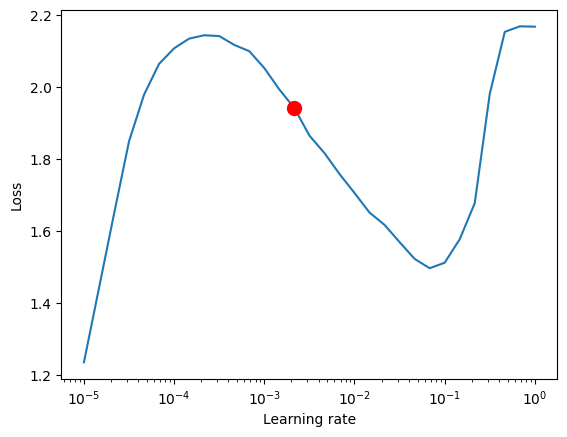

In [54]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=64

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config,batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup('fit')
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)

In [76]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.003
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20

lightning_module_config['others']['optimizer_params']['weight_decay']=1
lightning_module_config['others']['learning_rate']=0.003
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'max', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='fminst'
cl_config['wandb']['name']='resnet'

# data_module_config['data_module']['small_subset']=True
# data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup('fit')
trainer.fit(lightning_module, dm)

Global seed set to 42
/opt/homebrew/anaconda3/envs/adl/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/opt/homebrew/anaconda3/envs/adl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /Users/harikrishnad

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/adl/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


                                                                           Epoch 1: Val_Loss: 2.30, Val_Metric: 0.09 | 

/opt/homebrew/anaconda3/envs/adl/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 375/375 [00:32<00:00, 11.45it/s, v_num=nzlp, val_metric=0.854, train_metric=0.839].85 | Train_Loss: 0.44, Train_Metric: 0.84


Metric val_metric improved. New best score: 0.854


Epoch 2: 100%|██████████| 375/375 [00:31<00:00, 11.85it/s, v_num=nzlp, val_metric=0.852, train_metric=0.864]Epoch 3: Val_Loss: 0.43, Val_Metric: 0.85 | Train_Loss: 0.38, Train_Metric: 0.86
Epoch 00003: reducing learning rate of group 0 to 1.5000e-03.
Epoch 4: 100%|██████████| 375/375 [00:31<00:00, 11.82it/s, v_num=nzlp, val_metric=0.869, train_metric=0.886]Epoch 5: Val_Loss: 0.37, Val_Metric: 0.87 | 

Metric val_metric improved by 0.014 >= min_delta = 0.0. New best score: 0.869


Train_Loss: 0.32, Train_Metric: 0.89
Epoch 00005: reducing learning rate of group 0 to 7.5000e-04.
Epoch 5: 100%|██████████| 375/375 [00:31<00:00, 11.89it/s, v_num=nzlp, val_metric=0.886, train_metric=0.902]Epoch 6: Val_Loss: 0.31, Val_Metric: 0.89 | Train_Loss: 0.27, Train_Metric: 0.90


Metric val_metric improved by 0.017 >= min_delta = 0.0. New best score: 0.886


Epoch 00006: reducing learning rate of group 0 to 3.7500e-04.
Epoch 6: 100%|██████████| 375/375 [00:31<00:00, 11.86it/s, v_num=nzlp, val_metric=0.906, train_metric=0.918]Epoch 7: Val_Loss: 0.27, Val_Metric: 0.91 | 

Metric val_metric improved by 0.020 >= min_delta = 0.0. New best score: 0.906


Train_Loss: 0.23, Train_Metric: 0.92
Epoch 00007: reducing learning rate of group 0 to 1.8750e-04.
Epoch 7: 100%|██████████| 375/375 [00:31<00:00, 11.82it/s, v_num=nzlp, val_metric=0.910, train_metric=0.930]Epoch 8: Val_Loss: 0.25, Val_Metric: 0.91 | 

Metric val_metric improved by 0.004 >= min_delta = 0.0. New best score: 0.910


Train_Loss: 0.20, Train_Metric: 0.93
Epoch 00008: reducing learning rate of group 0 to 9.3750e-05.
Epoch 8: 100%|██████████| 375/375 [00:31<00:00, 11.85it/s, v_num=nzlp, val_metric=0.915, train_metric=0.938]Epoch 9: Val_Loss: 0.24, Val_Metric: 0.92 | 

Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.915


Train_Loss: 0.18, Train_Metric: 0.94
Epoch 00009: reducing learning rate of group 0 to 4.6875e-05.
Epoch 9: 100%|██████████| 375/375 [00:31<00:00, 11.85it/s, v_num=nzlp, val_metric=0.917, train_metric=0.945]Epoch 10: Val_Loss: 0.24, Val_Metric: 0.92 | 

Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.917


Train_Loss: 0.17, Train_Metric: 0.95


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.3438e-05.
Epoch 9: 100%|██████████| 375/375 [00:31<00:00, 11.80it/s, v_num=nzlp, val_metric=0.917, train_metric=0.945]


In [77]:
file = f"{trainer.logger.log_dir}/metrics.csv"
print(file)

/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_41/metrics.csv


In [78]:
import pandas as pd
df = pd.read_csv(file)
pd.DataFrame(df['val_metric'].dropna())

,val_metric
19,0.854417
41,0.829500
63,0.852417
85,0.770667
106,0.868833
128,0.886083
150,0.906167
172,0.909917
193,0.915167
215,0.917417


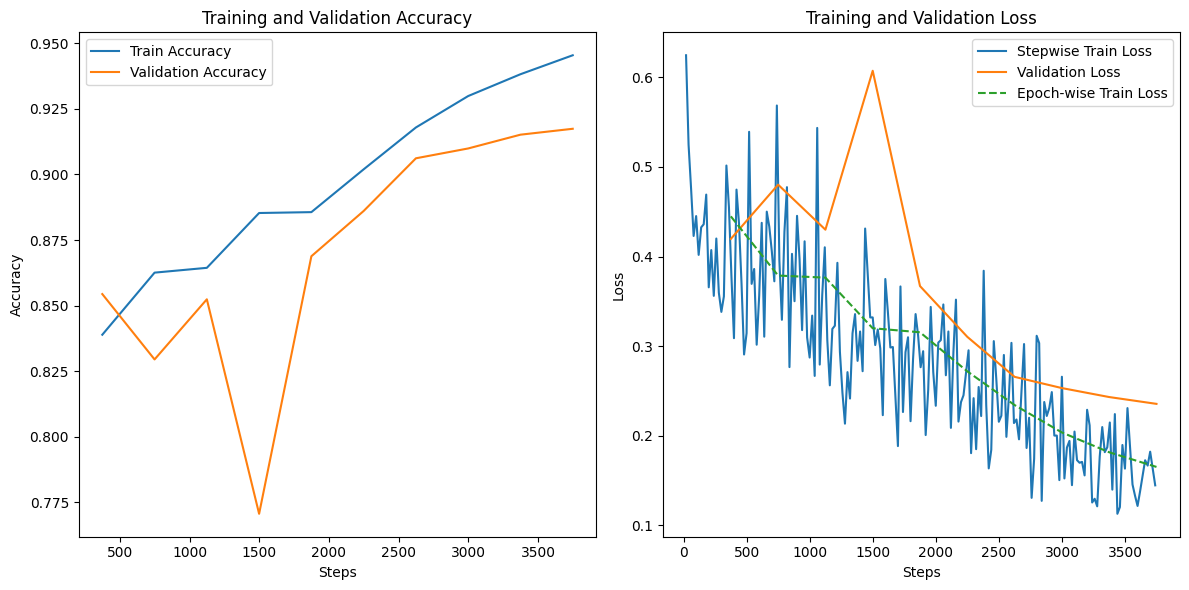

In [79]:
plot_losses_acc(file)

In [60]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.003
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20

lightning_module_config['others']['optimizer_params']['weight_decay']=10
lightning_module_config['others']['learning_rate']=0.003
# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.StepLR' # CODE HERE

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {'step_size':10, 'gamma': 0.5}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='fminst'
cl_config['wandb']['name']='resnet'

# data_module_config['data_module']['small_subset']=True
# data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup('fit')
trainer.fit(lightning_module, dm)

Global seed set to 42
/opt/homebrew/anaconda3/envs/adl/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/opt/homebrew/anaconda3/envs/adl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /Users/harikrishnad

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 13.17it/s]

/opt/homebrew/anaconda3/envs/adl/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


                                                                           Epoch 1: Val_Loss: 2.30, Val_Metric: 0.09 | 

/opt/homebrew/anaconda3/envs/adl/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 375/375 [00:34<00:00, 10.88it/s, v_num=nzlp, val_metric=0.522, train_metric=0.798].52 | 

Metric val_metric improved. New best score: 0.522


Train_Loss: 0.97, Train_Metric: 0.80
Epoch 5: 100%|██████████| 375/375 [00:31<00:00, 11.84it/s, v_num=nzlp, val_metric=0.219, train_metric=0.802]Epoch 6: Val_Loss: 2.01, Val_Metric: 0.22 | 

Monitored metric val_metric did not improve in the last 5 records. Best score: 0.522. Signaling Trainer to stop.


Train_Loss: 1.10, Train_Metric: 0.80
Epoch 5: 100%|██████████| 375/375 [00:31<00:00, 11.82it/s, v_num=nzlp, val_metric=0.219, train_metric=0.802]


In [61]:
file = f"{trainer.logger.log_dir}/metrics.csv"
print(file)

/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_37/metrics.csv


In [62]:
import pandas as pd
df = pd.read_csv(file)
pd.DataFrame(df['val_metric'].dropna())

,val_metric
19,0.521917
41,0.293917
63,0.477333
85,0.235083
106,0.470500
128,0.219167


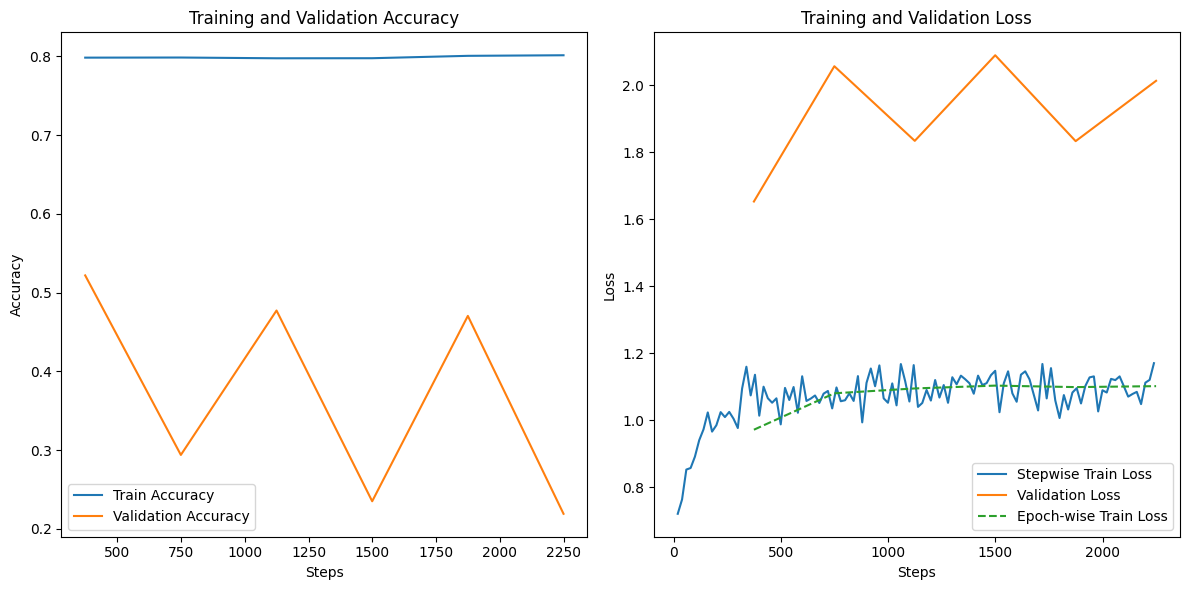

In [63]:
plot_losses_acc(file)